In [1]:
import pandas as pd

# Path to the CSV file
file_path = "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/prune_predictions_norm_off_bottleneck/RangePruning/pruning_analysis_results.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Filter rows where fold is 'all'
df_all_fold = df[df['fold'] == 'all']

# Split into two dataframes: one with min_val='0e+' and one without
df_with_0e = df_all_fold[df_all_fold['min_val'].astype(str).str.startswith('0e')].copy()
df_without_0e = df_all_fold[~df_all_fold['min_val'].astype(str).str.startswith('0e')]

# If there are rows with min_val='0e+', find the one with shortest prune_layers
if not df_with_0e.empty:
    # Calculate the length of prune_layers for each row
    df_with_0e.loc[:, 'prune_layers_length'] = df_with_0e['prune_layers'].str.len()

    # Get the row with the shortest prune_layers
    shortest_prune_layer_row = df_with_0e.loc[df_with_0e['prune_layers_length'].idxmin()]

    # Remove the temporary column
    shortest_prune_layer_row = shortest_prune_layer_row.drop('prune_layers_length')

    # Convert to DataFrame and concatenate with the other DataFrame
    df_filtered = pd.concat([df_without_0e, pd.DataFrame([shortest_prune_layer_row])])
else:
    df_filtered = df_without_0e

# Print the remaining data
print("Remaining data after filtering:")
print(df_filtered.to_string(index=False))

# Also provide some basic stats
print(f"\nNumber of rows remaining: {len(df_filtered)}")

Remaining data after filtering:
fold prune_method min_val max_val  prune_bias                                                                                                                                                                  prune_layers  prune_weights  model_type  performance_Dice  performance_FN  performance_FP  performance_IoU  performance_TN  performance_TP  performance_n_pred  performance_n_ref  weights_zeros  weights_total  weights_percentage  biases_zeros  biases_total  biases_percentage  total_zeros  total_total  total_percentage
 all RangePruning    -9e+     9e+        True encoder.stages.5.0.convs.0.conv-encoder.stages.5.0.convs.1.conv-decoder.transpconvs.0-decoder.transpconvs.1-decoder.transpconvs.2-decoder.transpconvs.3-decoder.transpconvs.4           True final_model          0.000016     6659.633333       53.556667         0.000008   528305.633333        0.056667           53.613333            6659.69        6463488       20605088               31.37        

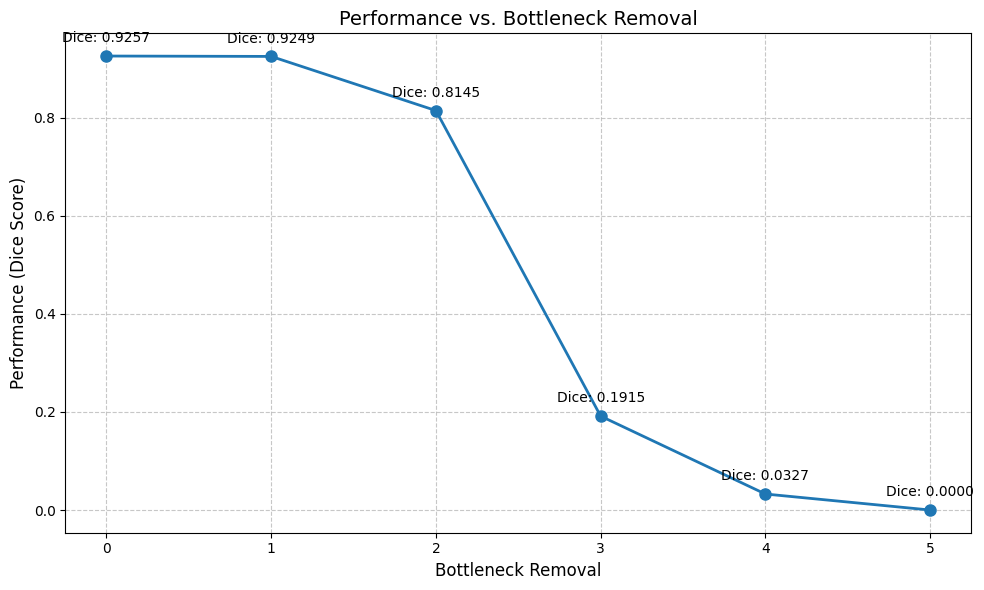


Graph has been saved as 'performance_vs_bottleneck_removal.png'


In [2]:
# Now create a plot
import matplotlib.pyplot as plt
import numpy as np

# Sort the dataframe by prune_layers length
df_filtered['prune_layers_length'] = df_filtered['prune_layers'].str.len()
df_filtered_sorted = df_filtered.sort_values('prune_layers_length')

# Create a 'bottleneck removal' column
# The entry with min_val='0e+' gets a value of 0, others increment by 1
df_filtered_sorted['bottleneck_removal'] = np.arange(len(df_filtered_sorted))
# If there's a 0e+ entry, make sure it gets a value of 0
if any(df_filtered_sorted['min_val'].astype(str).str.startswith('0e')):
    zero_idx = df_filtered_sorted['min_val'].astype(str).str.startswith('0e')
    non_zero_idx = ~zero_idx
    df_filtered_sorted.loc[zero_idx, 'bottleneck_removal'] = 0
    df_filtered_sorted.loc[non_zero_idx, 'bottleneck_removal'] = np.arange(1, sum(non_zero_idx) + 1)

# Now sort by the bottleneck_removal values to ensure proper ordering on x-axis
df_filtered_sorted = df_filtered_sorted.sort_values('bottleneck_removal')

# Create a nice figure
plt.figure(figsize=(10, 6))
plt.plot(df_filtered_sorted['bottleneck_removal'],
         df_filtered_sorted['performance_Dice'],
         'o-', linewidth=2, markersize=8)

# Add labels and title
plt.xlabel('Bottleneck Removal', fontsize=12)
plt.ylabel('Performance (Dice Score)', fontsize=12)
plt.title('Performance vs. Bottleneck Removal', fontsize=14)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Ensure the x-axis shows integer ticks
plt.xticks(df_filtered_sorted['bottleneck_removal'])

# Add annotations for each point showing the prune_layers length
for i, row in df_filtered_sorted.iterrows():
    plt.annotate(f"Dice: {row['performance_Dice']:.4f}",
                 (row['bottleneck_removal'], row['performance_Dice']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

# Save the figure
plt.tight_layout()
plt.savefig('performance_vs_bottleneck_removal.png')
plt.show()

print("\nGraph has been saved as 'performance_vs_bottleneck_removal.png'")